# Setup Devices

In [1]:
from ophyd import PVPositioner, EpicsSignal, EpicsSignalRO, EpicsMotor, Device
from bluesky.callbacks.mpl_plotting import LivePlot
from ophyd.status import Status, SubscriptionStatus
from ophyd import Component as Cpt
import matplotlib.pyplot as plt
from bluesky.plans import scan, count
from bluesky import RunEngine
import bluesky.plan_stubs as bps
from bluesky.callbacks import LiveTable
from time import sleep
import IPython
from bluesky.suspenders import SuspendBoolHigh

class Laser(PVPositioner):
    setpoint = Cpt(EpicsSignal, ':CYCLE')
    readback = Cpt(EpicsSignalRO, ':RBK')
    done = Cpt(EpicsSignalRO, ':DONE')
    enable = Cpt(EpicsSignal, ':ENABLE')
    interlock = EpicsSignal("laser:INTLK", name = "interlock")
    done_value = 1
    

class Motor(Device):
    rotation = Cpt(EpicsMotor, ':ROT')
    tilt = Cpt(EpicsMotor, ':TILT')
    trans = Cpt(EpicsMotor, ':TRANS')
    
class Picoammeter(Device):
    readback = Cpt(EpicsSignal, ':rdCur')
    proc = Cpt(EpicsSignal, ':rdCur.PROC')
    pact = Cpt(EpicsSignal, ':rdCur.PACT')
    readRange = Cpt(EpicsSignalRO, ':rdCRng')
    setRange = Cpt(EpicsSignal, ':setCRng')
    autoScan = Cpt(EpicsSignal, ':triggerSwitch')
    
    def trigger(self):
        self.proc.put(1, wait=True)
        def wait_for_value(*, old_value=None, value=None, **_):
            return value == 0
        status = SubscriptionStatus(self.pact, wait_for_value)
        # set up monitor status on self.readback with the above
        return status 

    #def read(self):
     #   return self.readback.read()
        

**** The executable "caRepeater" couldn't be located
**** because of errno = "No such file or directory".
**** You may need to modify your PATH environment variable.
**** Unable to start "CA Repeater" process.


In [14]:
RE = RunEngine()

In [15]:
laser = Laser('laser', name="laser")
laser.wait_for_connection()
smaract = Motor('GRATING', name="smaract")
smaract.wait_for_connection()
meter = Picoammeter('Diode', name = "meter")
meter.wait_for_connection()

In [16]:
susp = SuspendBoolHigh(laser.interlock, sleep = 1.0)
RE.install_suspender(susp)

In [17]:
import time

def current_milli_time():
    return round(time.time() * 1000)

# Measurements

In [18]:
token = RE.subscribe(LiveTable(["meter_readback"]))
live_plot = LivePlot('meter_readback', 'smaract_rotation')
token1 = RE.subscribe(live_plot)

In [19]:
def custom_reading(devices):
    laser.set(0)
    yield from bps.trigger_and_read(devices)
    
    laser.set(100)
    yield from bps.trigger_and_read(devices)

In [20]:
def custom_step(detectors, step, pos_cache):
    yield from bps.one_nd_step(detectors, step, pos_cache, take_reading=custom_reading)

In [21]:
def diff_scan(devices, motor, start, stop, steps, noise_flag=False):
    meter.autoScan.put(0, wait=True)
    if noise_flag:
        yield from scan([meter], motor, start, stop, steps, per_step=custom_step)
    else:
        laser.set(100)
        yield from scan([meter], motor, start, stop, steps)
    meter.autoScan.put(1, wait=True)

In [23]:
run_millis = current_milli_time()

from databroker import Broker
db = Broker.named('temp')
RE.subscribe(db.insert)
# scan_data, = RE(diff_scan([meter], smaract.rotation, 0, 1500000, 20, noise_flag=True), live_plot)
scan_data, = RE(diff_scan([meter], smaract.rotation, -50000000, 50000000, 100), live_plot)



+-----------+------------+----------------+
|   seq_num |       time | meter_readback |
+-----------+------------+----------------+
|         1 | 13:46:42.3 |   0.0000014031 |
|         2 | 13:46:42.7 |   0.0000014069 |
|         3 | 13:46:43.2 |   0.0000013886 |
|         4 | 13:46:43.8 |   0.0000013945 |
|         5 | 13:46:44.3 |   0.0000014157 |
|         6 | 13:46:45.0 |   0.0000014069 |
|         7 | 13:46:45.6 |   0.0000014452 |
|         8 | 13:46:46.3 |   0.0000029783 |
|         9 | 13:46:46.8 |   0.0000025859 |
|        10 | 13:46:47.4 |   0.0000014268 |
|        11 | 13:46:47.9 |   0.0000014149 |
|        12 | 13:46:48.4 |   0.0000014025 |
|        13 | 13:46:49.0 |   0.0000014113 |
|        14 | 13:46:49.5 |   0.0000014151 |
|        15 | 13:46:50.1 |   0.0000014158 |
|        16 | 13:46:50.7 |   0.0000014177 |
|        17 | 13:46:51.2 |   0.0000014155 |
|        18 | 13:46:51.6 |   0.0000014119 |
|        19 | 13:46:52.2 |   0.0000014252 |
|        20 | 13:46:52.8 |   0

# Data Analysis

In [26]:
db[scan_data]

In [22]:
header = db[scan_data]
wavelength = 650e-9

data = header.table()
time = data.time
rbk = data.meter_readback
rot = data.smaract_rotation

In [52]:
data_bg = data.iloc[::2]
data_laser = data.iloc[1::2]

In [51]:
data_bg['meter_readback']

seq_num
1     0.000003
3     0.000003
5     0.000003
7     0.000003
9     0.000003
11    0.000003
13    0.000003
15    0.000003
17    0.000003
19    0.000003
21    0.000003
23    0.000003
25    0.000003
27    0.000003
29    0.000003
31    0.000003
33    0.000003
35    0.000003
37    0.000003
39    0.000003
Name: meter_readback, dtype: float64

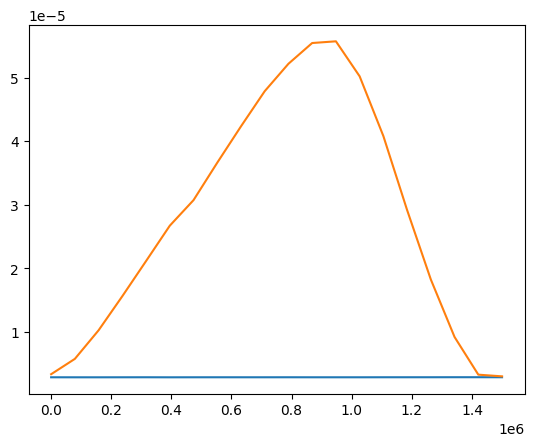

In [54]:
plt.plot(data_bg['smaract_rotation'], data_bg['meter_readback'])
plt.plot(data_laser['smaract_rotation'], data_laser['meter_readback'])

plt.show()

In [55]:
angle = data_laser['smaract_rotation'].to_numpy()/1e6
rb_clean = data_laser['meter_readback'].to_numpy() - data_bg['meter_readback'].to_numpy()
angle, rb_clean

(array([4.400000e-05, 7.892200e-02, 1.578460e-01, 2.367560e-01,
        3.157660e-01, 3.946930e-01, 4.736770e-01, 5.526170e-01,
        6.316220e-01, 7.104920e-01, 7.894360e-01, 8.683660e-01,
        9.473580e-01, 1.026294e+00, 1.105257e+00, 1.184148e+00,
        1.263122e+00, 1.342043e+00, 1.421026e+00, 1.499991e+00]),
 array([4.83600e-07, 2.89730e-06, 7.38980e-06, 1.27414e-05, 1.82676e-05,
        2.38325e-05, 2.78473e-05, 3.37325e-05, 3.94510e-05, 4.49733e-05,
        4.92808e-05, 5.25466e-05, 5.28151e-05, 4.73110e-05, 3.79082e-05,
        2.62850e-05, 1.53614e-05, 6.31920e-06, 4.00600e-07, 1.41200e-07]))

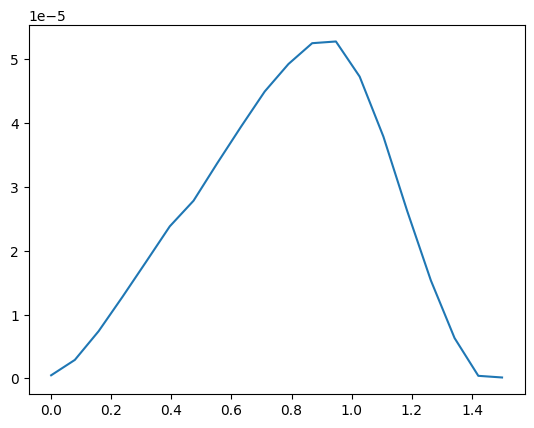

In [56]:
plt.plot(angle, rb_clean)
plt.show()

In [66]:
import numpy as np 
import pandas as pd

df = pd.DataFrame()
df['angle_deg'] = angle
df['cur_A'] = rb_clean

df.to_csv(f'run_{run_millis}.csv', index=False)